In [1]:
import ast
import cv2
import numpy as np
import os
import pandas as pd
import random
import torch

from collections import Counter
from tqdm.notebook import tqdm
from ultralytics import YOLO

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [20, 15]

In [2]:
def imread(filename):
    return cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)

data_folder = 'screw/'
imfiles = os.listdir(os.path.join(data_folder, 'images'))
imfiles = [os.path.join(data_folder, 'images', f) for f in imfiles if os.path.splitext(f)[-1] == '.jpeg']

sample = random.choice(imfiles)
image = imread(sample)
rows, cols, channels = image.shape

In [3]:
def geo_to_ndarray(x): 
    return np.array(ast.literal_eval(x))

annotations = pd.read_csv('screw/annotations.csv', 
                          converters={'geometry': geo_to_ndarray})
annotations

id       image_id                                           geometry  \
0      0  IMG_0835.jpeg  [[1057, 442], [1418, 442], [1418, 639], [1057,...   
1      1  IMG_0835.jpeg  [[2132, 533], [2369, 533], [2369, 891], [2132,...   
2      2  IMG_0835.jpeg  [[1012, 1107], [1214, 1107], [1214, 1488], [10...   
3      3  IMG_0835.jpeg  [[1801, 1658], [2043, 1658], [2043, 2034], [18...   
4      4  IMG_0835.jpeg  [[1272, 1904], [1626, 1904], [1626, 2177], [12...   
..   ...            ...                                                ...   
139  139  IMG_0826.jpeg  [[2029, 1317], [2302, 1317], [2302, 1519], [20...   
140  140  IMG_0826.jpeg  [[995, 1646], [1304, 1646], [1304, 1841], [995...   
141  141  IMG_0826.jpeg  [[1882, 2654], [2054, 2654], [2054, 2945], [18...   
142  142  IMG_0826.jpeg  [[2265, 3031], [2404, 3031], [2404, 3333], [22...   
143  143  IMG_0826.jpeg  [[1196, 3214], [1402, 3214], [1402, 3492], [11...   

     class  
0    screw  
1    screw  
2    screw  
3    screw  
4    screw  
..     ...  
139  screw  
140  screw  
141  screw  
142  screw  
143  screw  

[144 rows x 4 columns]

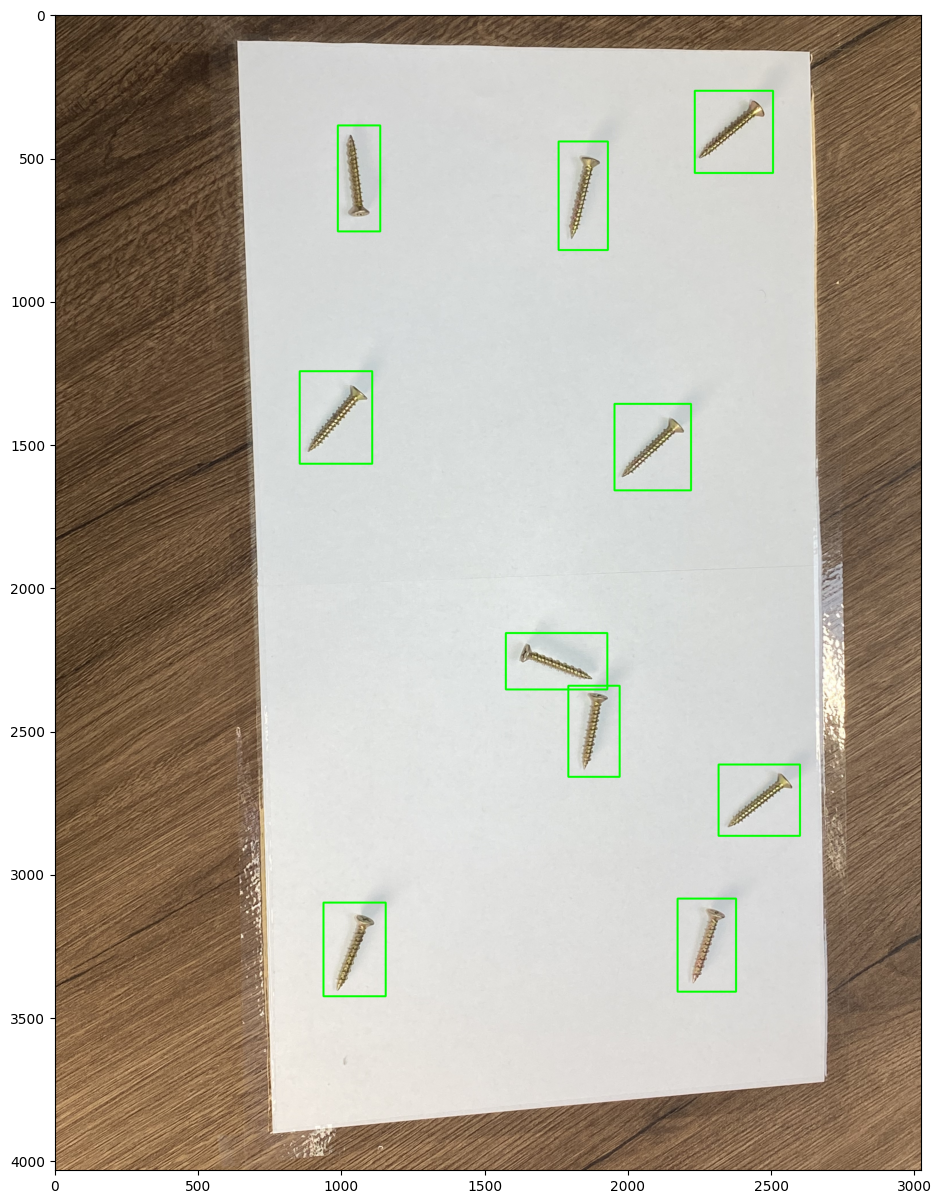

In [4]:
sample = random.choice(imfiles)
image = imread(sample)

labels = annotations[annotations.image_id == os.path.basename(sample)]
points = [geo.reshape((-1, 1, 2)) for geo in labels.geometry]
cv2.polylines(image, points, isClosed=True, color=(0, 255, 0), thickness=5)

plt.imshow(image)

In [5]:
def recompute_box_coors(box, x_origin, y_origin, width, height, threshold):
    """Recompute box coordinates to new origin
    
    Args:
        box (np.ndarray): Bounding box coordinates in form (x_min, y_min, x_max, y_max).
        x_origin (int): X coordinate of the origin of the new coordinate system.
        y_origin (int): Y coordinate of the origin of the new coordinate system.
        width (int): Width of the new coordinate system. Recomputed box coordinates
            that would fall beyond will be truncated.
        threshold (float): Rejection ratio of bounding box after truncation. Recomputed
            boxes that are heavily truncated will be discarded.
            
    Returns:
        (tuple): Recomputed bounding boxes in YOLOv8 data format.
        
    """
    # Recompute bounds coordinates to new reference
    x_min, y_min, x_max, y_max = box
    x_min, y_min, x_max, y_max = x_min - x_origin, y_min - y_origin, x_max - x_origin, y_max - y_origin

    # Return None if the box does not lie within image crop
    if (x_min > width) or (x_max < 0.0) or (y_min > height) or (y_max < 0.0):
        return None
    
    # Truncate box x coordinates if necessary
    x_max_trunc = min(x_max, width)
    x_min_trunc = max(x_min, 0)
    # Skip if truncate too much
    if (x_max_trunc - x_min_trunc) / (x_max - x_min) < threshold:
        return None

    # Repeat for y coordinates
    y_max_trunc = min(y_max, width) 
    y_min_trunc = max(y_min, 0) 
    if (y_max_trunc - y_min_trunc) / (y_max - y_min) < threshold:
        return None
        
    # Convert to YOLOv8 format
    x_center = (x_min_trunc + x_max_trunc) / 2.0 / width
    y_center = (y_min_trunc + y_max_trunc) / 2.0 / height
    x_extend = (x_max_trunc - x_min_trunc) / width
    y_extend = (y_max_trunc - y_min_trunc) / height
    
    return (0, x_center, y_center, x_extend, y_extend)

In [6]:
def get_boxes(geometry):
    return np.min(geometry[:, 0]), np.min(geometry[:, 1]), np.max(geometry[:, 0]), np.max(geometry[:, 1])

annotations.loc[:,'boxes'] = annotations.loc[:,'geometry'].apply(get_boxes)
annotations.head(10)

id       image_id                                           geometry  \
0   0  IMG_0835.jpeg  [[1057, 442], [1418, 442], [1418, 639], [1057,...   
1   1  IMG_0835.jpeg  [[2132, 533], [2369, 533], [2369, 891], [2132,...   
2   2  IMG_0835.jpeg  [[1012, 1107], [1214, 1107], [1214, 1488], [10...   
3   3  IMG_0835.jpeg  [[1801, 1658], [2043, 1658], [2043, 2034], [18...   
4   4  IMG_0835.jpeg  [[1272, 1904], [1626, 1904], [1626, 2177], [12...   
5   5  IMG_0835.jpeg  [[2155, 2110], [2464, 2110], [2464, 2428], [21...   
6   6  IMG_0835.jpeg  [[2007, 2692], [2352, 2692], [2352, 3024], [20...   
7   7  IMG_0835.jpeg  [[1299, 2831], [1644, 2831], [1644, 3077], [12...   
8   8  IMG_0835.jpeg  [[1250, 3208], [1384, 3208], [1384, 3580], [12...   
9   9  IMG_0835.jpeg  [[2271, 3329], [2513, 3329], [2513, 3652], [22...   

   class                     boxes  
0  screw    (1057, 442, 1418, 639)  
1  screw    (2132, 533, 2369, 891)  
2  screw  (1012, 1107, 1214, 1488)  
3  screw  (1801, 1658, 2043, 2034)  
4  screw  (1272, 1904, 1626, 2177)  
5  screw  (2155, 2110, 2464, 2428)  
6  screw  (2007, 2692, 2352, 3024)  
7  screw  (1299, 2831, 1644, 3077)  
8  screw  (1250, 3208, 1384, 3580)  
9  screw  (2271, 3329, 2513, 3652)

In [7]:
fnames = list(annotations['image_id'].unique())
np.random.shuffle(fnames)
train_split = fnames[0:int(len(fnames)*0.8)]

print('Num samples', len(fnames))
print('Train split', len(train_split))
print('Val split  ', len(fnames) - len(train_split))

Num samples 14
Train split 11
Val split   3


In [8]:
folder_crops = {'train': 'screw/train/images/',
                'val': 'screw/val/images/'}

folder_labels = {'train': 'screw/train/labels/',
                 'val': 'screw/val/labels/'}

for folders in [folder_crops, folder_labels]:
    for _, folder in folders.items():
        print('check', folder)
        if not os.path.isdir(folder):
            os.makedirs(folder)
        else:
            print('clean', folder)
            for file in os.listdir(folder):
                os.remove(os.path.join(folder, file))

check screw/train/images/
clean screw/train/images/
check screw/val/images/
clean screw/val/images/
check screw/train/labels/
clean screw/train/labels/
check screw/val/labels/
clean screw/val/labels/


In [9]:
crop_size = 640
crop_overlap = 64
trunc_th = 0.3
step = crop_size - crop_overlap


for imfile in (imfiles):    
    image = cv2.imread(imfile)
    folder = 'train' if os.path.basename(imfile) in train_split else 'val'

    # Get annotations for image
    labels = annotations[annotations['image_id'] == os.path.basename(imfile)]
    img_id = os.path.splitext(os.path.basename(imfile))[0]    
 
    # Extract crops
    for x_start in tqdm(np.arange(0, cols - crop_size, step)):
        for y_start in np.arange(0, rows - crop_size, step):

            x_end = x_start + crop_size
            y_end = y_start + crop_size
            
            filename_crop = os.path.join(folder_crops[folder],
                                         img_id + '_' + str(x_start) + '_' + str(y_start) + '.jpg')
            filename_label = os.path.join(folder_labels[folder],
                                          img_id + '_' + str(x_start) + '_' + str(y_start) + '.txt')
                                        
            crop = image[y_start:y_end, x_start:x_end, :]
            assert crop.shape == (crop_size, crop_size, channels)                
            cv2.imwrite(filename_crop, crop)

            boxes = [recompute_box_coors(boxes, x_start, y_start, crop_size, crop_size, trunc_th)
                     for boxes in labels['boxes']]
            boxes = [box for box in boxes if box is not None]            

            # save labels
            with open(filename_label, 'w+') as f:
                for box in boxes:
                    f.write(' '.join(str(x) for x in box) + '\n')

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[          0     0.57969     0.15234     0.29375     0.30469]
370.99998474121094 97.5


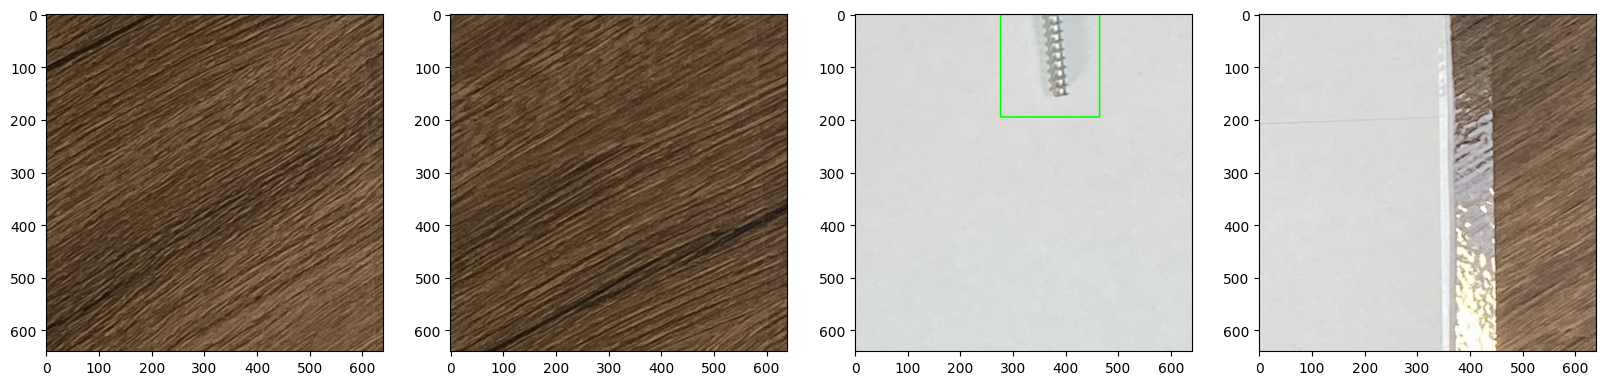

In [22]:
for idx, sample in enumerate(np.random.choice(os.listdir(folder_crops['train']), 4)):
    
    # Load image and corresponding labels
    image = imread(os.path.join(folder_crops['train'], sample))
    with open(os.path.join(folder_labels['train'], sample.replace('.jpg', '.txt')), 'r') as f:
        labels = f.readlines()

    for box in labels:
        box = np.array([d for d in box.split(' ')], dtype=np.float32)
        print(box)
        # Undo coordinate normalization
        x_center = box[1] * crop_size
        y_center = box[2] * crop_size
        print(x_center, y_center)

        width = box[3] * crop_size
        height = box[4] * crop_size

        # Convert from YOLOv8 format to OpenCV rectangle format
        x_start, y_start = int(x_center - width/2), int(y_center - height/2)
        x_end, y_end = int(x_center + width/2), int(y_center + height/2)

        cv2.rectangle(image, (x_start, y_start), (x_end, y_end), color=(0, 255, 0), thickness=2)

    plt.subplot(1,4,idx+1), plt.imshow(image)

In [31]:
model = YOLO("yolov8n.pt")
model.info()

YOLOv8n summary: 225 layers, 3157200 parameters, 0 gradients, 8.9 GFLOPs


(225, 3157200, 0, 8.8575488)

In [32]:
model

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s


0: 640x416 3 kites, 53.6ms
Speed: 2.4ms preprocess, 53.6ms inference, 614.3ms postprocess per image at shape (1, 3, 640, 416)

0: 640x416 2 kites, 53.7ms
Speed: 2.9ms preprocess, 53.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 416)

0: 640x416 2 kites, 48.9ms
Speed: 1.6ms preprocess, 48.9ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 416)

0: 640x416 3 kites, 56.9ms
Speed: 1.5ms preprocess, 56.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 416)


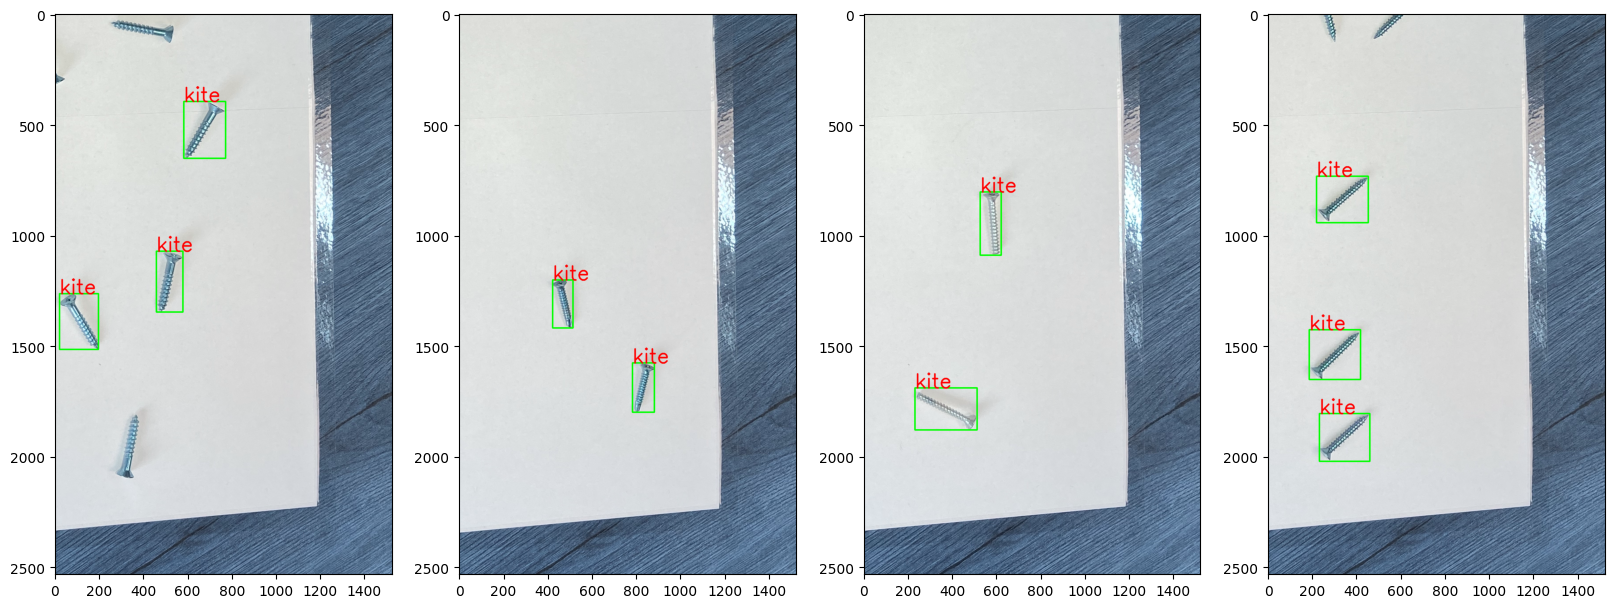

In [33]:
for idx, sample in enumerate(np.random.choice(imfiles, 4)):
    image = cv2.imread(sample)
    image = image[1500:, 1500:, :]

    result = model.predict(image, conf=0.2)[0]
    boxes = result.boxes.cpu().numpy().xyxy.astype(np.int16)

    for box_idx, box in enumerate(boxes):
        start, stop = box[0:2], box[2:]
        cv2.rectangle(image, start, stop, color=(0, 255, 0), thickness=5)
        font = cv2.FONT_HERSHEY_SIMPLEX
        image = cv2.putText(image, result.names[result.boxes.cls[box_idx].item()], (box[0], box[1]),
                            cv2.FONT_HERSHEY_SIMPLEX, 3, (255, 0, 0), 6, cv2.LINE_AA)

    plt.subplot(1,4,idx+1), plt.imshow(image)

In [34]:
config = """
# train and val datasets (image directory or *.txt file with image paths)
train: screw/train
val: screw/val

# number of classes
nc: 1

# class names
names: ['screw']
"""

with open("data.yaml", "w") as f:
    f.write(config)

In [35]:
root = "/Users/ufuran/Documents/project_work/project_cv_work/"
!yolo task=detect mode=train model=yolov8n.pt data={root}/data.yaml epochs=10 imgsz=640 mosaic=0.0 flipud=0.5 scale=0.0 device=mps

Ultralytics YOLOv8.1.43 🚀 Python-3.12.2 torch-2.2.2 MPS (Apple M2)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/Users/ufuran/Documents/project_work/project_cv_work//data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=mps, workers=8, project=None, name=train9, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show

In [36]:
retrained = YOLO('/Users/ufuran/Documents/project_work/project_cv_work/runs/detect/train9/weights/best.pt')


0: 640x352 (no detections), 74.7ms
Speed: 2.8ms preprocess, 74.7ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 352)
{0: 'screw'}

0: 640x352 (no detections), 39.5ms
Speed: 1.5ms preprocess, 39.5ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 352)
{0: 'screw'}

0: 640x352 (no detections), 39.0ms
Speed: 1.3ms preprocess, 39.0ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 352)
{0: 'screw'}

0: 640x352 (no detections), 36.6ms
Speed: 1.3ms preprocess, 36.6ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 352)
{0: 'screw'}


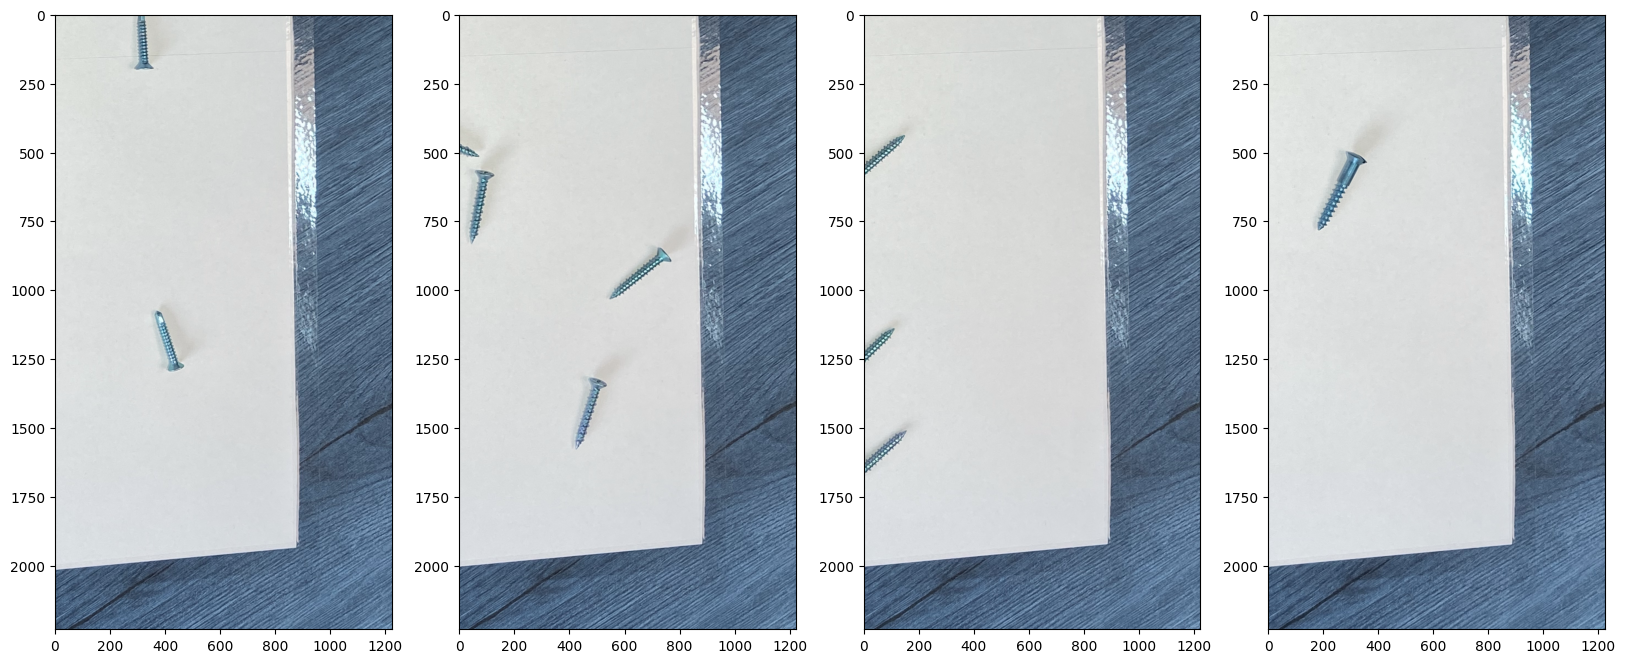

In [41]:
for idx, sample in enumerate(np.random.choice(imfiles, 4)):
    image = cv2.imread(sample)
    image = image[1800:, 1800:, :]

    # result = model.predict(image, conf=0.2)[0]
    # boxes = result.boxes.cpu().numpy().xyxy.astype(np.int16)

    # for box_idx, box in enumerate(boxes):
    #     start, stop = box[0:2], box[2:]
    #     cv2.rectangle(image, start, stop, color=(0, 255, 0), thickness=5)
    #     font = cv2.FONT_HERSHEY_SIMPLEX
    #     image = cv2.putText(image, result.names[result.boxes.cls[box_idx].item()], (box[0], box[1]),
    #                         cv2.FONT_HERSHEY_SIMPLEX, 3, (255, 0, 0), 6, cv2.LINE_AA)
        
    result = retrained.predict(image, conf=0.2)[0]
    print(result.names)
    boxes = result.boxes.cpu().numpy().xyxy.astype(np.int16)

    for box_idx, box in enumerate(boxes):
        start, stop = box[0:2], box[2:]
        cv2.rectangle(image, start, stop, color=(0, 0, 255), thickness=5)
        font = cv2.FONT_HERSHEY_SIMPLEX
        image = cv2.putText(image, result.names[result.boxes.cls[box_idx].item()], (box[0], box[1]),
                            cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 6, cv2.LINE_AA)

    plt.subplot(1,4,idx+1), plt.imshow(image)